# League Champion Recommendation
## Exploratory Data Analysis

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import tree

#### Import Master Queue Match List

In [2]:
master_queue = pd.read_csv('Raw Data/master_solo_queue.csv')

In [3]:
master_queue.head()

,accountId,summonerName,wins,losses,leaguePoints,totalGames,platformId,gameId,champion,queue,season,timestamp,role,lane,name,key
0,Pb8X7C9AQZl3bD-wCBpc1EECbyOegdE1Ubc55DKi_NI8pBM,egril,39,26,47,109,NA1,3824046665,147,420,13,1615664062098,DUO_SUPPORT,BOTTOM,NaN,NaN
1,Pb8X7C9AQZl3bD-wCBpc1EECbyOegdE1Ubc55DKi_NI8pBM,egril,39,26,47,109,NA1,3822384968,117,420,13,1615573259663,DUO_SUPPORT,BOTTOM,Lulu,117.0
2,Pb8X7C9AQZl3bD-wCBpc1EECbyOegdE1Ubc55DKi_NI8pBM,egril,39,26,47,109,NA1,3822382300,117,420,13,1615571551937,DUO_SUPPORT,NONE,Lulu,117.0
3,Pb8X7C9AQZl3bD-wCBpc1EECbyOegdE1Ubc55DKi_NI8pBM,egril,39,26,47,109,NA1,3822259561,117,420,13,1615568525952,DUO_SUPPORT,BOTTOM,Lulu,117.0
4,Pb8X7C9AQZl3bD-wCBpc1EECbyOegdE1Ubc55DKi_NI8pBM,egril,39,26,47,109,NA1,3819479474,117,420,13,1615397061960,DUO_SUPPORT,BOTTOM,Lulu,117.0


In [4]:
master_queue.tail()

,accountId,summonerName,wins,losses,leaguePoints,totalGames,platformId,gameId,champion,queue,season,timestamp,role,lane,name,key
123683,Dgg9WkvkFtjkJR8McCu2jImw0uc4K25t7rzirqqXbxckdNU,Sandflame,126,129,99,1104,NA1,3771114383,58,420,13,1612306407403,SOLO,TOP,Renekton,58.0
123684,Dgg9WkvkFtjkJR8McCu2jImw0uc4K25t7rzirqqXbxckdNU,Sandflame,126,129,99,1104,NA1,3771103753,54,420,13,1612305879662,DUO,NONE,Malphite,54.0
123685,Dgg9WkvkFtjkJR8McCu2jImw0uc4K25t7rzirqqXbxckdNU,Sandflame,126,129,99,1104,NA1,3771087246,79,420,13,1612303455526,SOLO,TOP,Gragas,79.0
123686,Dgg9WkvkFtjkJR8McCu2jImw0uc4K25t7rzirqqXbxckdNU,Sandflame,126,129,99,1104,NA1,3771091499,150,420,13,1612300705923,SOLO,TOP,Gnar,150.0
123687,Dgg9WkvkFtjkJR8McCu2jImw0uc4K25t7rzirqqXbxckdNU,Sandflame,126,129,99,1104,NA1,3771016572,150,420,13,1612297992637,SOLO,TOP,Gnar,150.0


##### Check that only ranked solo data (code = 420) is in the dataset

In [5]:
master_queue.queue.unique()

array([420])

In [6]:
master_queue.columns

Index(['accountId', 'summonerName', 'wins', 'losses', 'leaguePoints',
       'totalGames', 'platformId', 'gameId', 'champion', 'queue', 'season',
       'timestamp', 'role', 'lane', 'name', 'key'],
      dtype='object')

#### Match info by team (including bans)

In [7]:
master_queue_match_team = pd.read_csv('Raw Data/match_team_info.csv')

In [8]:
master_queue_match_team.head()

,gameId,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,championId,pickTurn
0,3824046665,100,Win,True,True,True,True,True,True,7,1,2,2,0,2,0,77,1
1,3824046665,100,Win,True,True,True,True,True,True,7,1,2,2,0,2,0,80,2
2,3824046665,100,Win,True,True,True,True,True,True,7,1,2,2,0,2,0,526,3
3,3824046665,100,Win,True,True,True,True,True,True,7,1,2,2,0,2,0,234,4
4,3824046665,100,Win,True,True,True,True,True,True,7,1,2,2,0,2,0,412,5


In [9]:
master_queue_match_team['bans'] = master_queue_match_team.groupby(['gameId', 'teamId']).cumcount()+1

In [10]:
master_queue_match_team_wide = master_queue_match_team.pivot_table(
    index = ['gameId', 'teamId', 'baronKills', 'dragonKills', 'riftHeraldKills'],
    columns = 'bans',
    values = 'championId'
).add_prefix('ban_')
master_queue_match_team_wide = master_queue_match_team_wide.reset_index()

In [11]:
master_queue_match_team_wide.head(10)

bans,gameId,teamId,baronKills,dragonKills,riftHeraldKills,ban_1,ban_2,ban_3,ban_4,ban_5
0,3814858585,100,0,1,0,81,147,23,246,876
1,3814858585,200,1,2,2,38,164,77,145,103
2,3815618054,100,0,1,0,150,777,120,89,77
3,3815618054,200,0,1,1,120,122,38,526,147
4,3817332111,100,0,0,0,412,157,235,526,122
5,3817332111,200,0,2,1,104,145,526,114,105
6,3817468541,100,0,1,1,777,120,38,23,105
7,3817468541,200,1,3,0,85,145,120,121,234
8,3817591435,100,0,0,0,141,526,777,53,142
9,3817591435,200,0,2,2,91,-1,3,120,427


#### Match info by players

In [12]:
master_queue_match_pts = pd.read_csv('Raw Data/match_pt_info.csv')

In [13]:
master_queue_match_pts.head()

,gameId,participantId,teamId,championId,spell1Id,spell2Id,stats.participantId,stats.win,stats.item0,stats.item1,...,timeline.damageTakenDiffPerMinDeltas.30-end,timeline.damageTakenDiffPerMinDeltas.20-30,player.platformId,player.accountId,player.summonerName,player.summonerId,player.currentPlatformId,player.currentAccountId,player.matchHistoryUri,player.profileIcon
0,3824046665,1,100,43,4,14,1,True,3222,3853,...,NaN,NaN,NaN,aE_8EFFhet-9T8T-6uVuYIUGpB-dkccgQMagzL5sKP9ejA,ImbaDreaMeR,Sqxuz8V75oo3uJkYC7QAasVD0_HJmiZxJg-e4WXIgEpLnDY,NA1,aE_8EFFhet-9T8T-6uVuYIUGpB-dkccgQMagzL5sKP9ejA,/v1/stats/player_history/NA/35880511,4027
1,3824046665,2,100,777,4,12,2,True,3072,2420,...,NaN,NaN,NA1,GMliPyAsexA7G281yeS6v-V_b5RakmqYtteHoqGOB6NYTA,Enjin,dGQFMlY2TbjzhN9vd7Yai88ty3VeHBQ7DLCntGoberDUtfg,NA1,GMliPyAsexA7G281yeS6v-V_b5RakmqYtteHoqGOB6NYTA,/v1/stats/player_history/NA1/45449841,10
2,3824046665,3,100,85,12,4,3,True,3152,3157,...,NaN,NaN,NaN,4xL8m8aW1pwq0kW99t8qMjjgFwrj_U5wPZtFUPspAbxJ-w,llIIlIl,p120vHCD102yIJmjv5fdFmZtYaXLWHlDJkcPHB8vGE813Os,NA1,4xL8m8aW1pwq0kW99t8qMjjgFwrj_U5wPZtFUPspAbxJ-w,/v1/stats/player_history/NA/32944345,23
3,3824046665,4,100,29,4,7,4,True,2421,3115,...,NaN,NaN,NA1,ufUHbvKIdA0HM75opG3hrJx32z01WNP7_ci4FY8X8ZKPkQ...,IlIlIlIlIIlllIII,NLWM8aol0Gzoio-_BGXjNjU5QmMOMa6SY0cjEaHo4d-Cqb...,NA1,ufUHbvKIdA0HM75opG3hrJx32z01WNP7_ci4FY8X8ZKPkQ...,/v1/stats/player_history/NA1/2566402092959584,3788
4,3824046665,5,100,2,11,4,5,True,3067,3143,...,NaN,NaN,NA1,7kuczH3w3aaDk4cGfsH7r3HDcYVp05bxu-TvDLW5ojvQVz...,love nidalee,KHCNzS0g2YJCyKgtF5JNOPG6St7idXhmkkx6geIxFgEJZQ...,NA1,7kuczH3w3aaDk4cGfsH7r3HDcYVp05bxu-TvDLW5ojvQVz...,/v1/stats/player_history/NA1/2675420347246272,4881


In [14]:
master_queue_match_pts.columns

Index(['gameId', 'participantId', 'teamId', 'championId', 'spell1Id',
       'spell2Id', 'stats.participantId', 'stats.win', 'stats.item0',
       'stats.item1',
       ...
       'timeline.damageTakenDiffPerMinDeltas.30-end',
       'timeline.damageTakenDiffPerMinDeltas.20-30', 'player.platformId',
       'player.accountId', 'player.summonerName', 'player.summonerId',
       'player.currentPlatformId', 'player.currentAccountId',
       'player.matchHistoryUri', 'player.profileIcon'],
      dtype='object', length=149)

##### Define relevant stats to extract

In [15]:
stats = ['gameId', 'teamId', 'championId',
         'stats.win', 'stats.kills', 'stats.deaths', 'stats.assists',
        'stats.magicDamageDealtToChampions', 'stats.physicalDamageDealtToChampions',
        'stats.trueDamageDealtToChampions', 'stats.visionScore',
        'stats.turretKills', 'stats.inhibitorKills', 'stats.totalMinionsKilled',
        'stats.champLevel', 'stats.wardsPlaced', 'stats.wardsKilled', 'stats.firstBloodKill',
        'timeline.creepsPerMinDeltas.0-10', 'timeline.creepsPerMinDeltas.10-20',
         'timeline.creepsPerMinDeltas.20-30', 'timeline.role', 'timeline.lane', 
         'timeline.csDiffPerMinDeltas.0-10', 'timeline.csDiffPerMinDeltas.10-20',
        'timeline.csDiffPerMinDeltas.20-30']

In [16]:
players_df = master_queue_match_pts[stats].merge(master_queue_match_team_wide,
                                                on = ['gameId', 'teamId']).drop(['gameId', 'teamId'], axis=1)
players_df['stats.win'] = players_df['stats.win'].astype(int)

In [17]:
players_df.head()

,championId,stats.win,stats.kills,stats.deaths,stats.assists,stats.magicDamageDealtToChampions,stats.physicalDamageDealtToChampions,stats.trueDamageDealtToChampions,stats.visionScore,stats.turretKills,...,timeline.csDiffPerMinDeltas.10-20,timeline.csDiffPerMinDeltas.20-30,baronKills,dragonKills,riftHeraldKills,ban_1,ban_2,ban_3,ban_4,ban_5
0,43,1,1,3,19,5977,586,246,79,2,...,NaN,NaN,2,2,2,77,80,526,234,412
1,777,1,7,6,9,4440,14727,3231,35,1,...,NaN,NaN,2,2,2,77,80,526,234,412
2,85,1,5,7,7,21649,4898,0,27,2,...,NaN,NaN,2,2,2,77,80,526,234,412
3,29,1,6,8,10,9699,8440,9686,21,0,...,NaN,NaN,2,2,2,77,80,526,234,412
4,2,1,11,5,9,0,16863,7392,46,2,...,NaN,NaN,2,2,2,77,80,526,234,412


In [18]:
players_df.isna().sum()

championId                                0
stats.win                                 0
stats.kills                               0
stats.deaths                              0
stats.assists                             0
stats.magicDamageDealtToChampions         0
stats.physicalDamageDealtToChampions      0
stats.trueDamageDealtToChampions          0
stats.visionScore                         0
stats.turretKills                         0
stats.inhibitorKills                      0
stats.totalMinionsKilled                  0
stats.champLevel                          0
stats.wardsPlaced                         0
stats.wardsKilled                         0
stats.firstBloodKill                      0
timeline.creepsPerMinDeltas.0-10          0
timeline.creepsPerMinDeltas.10-20        40
timeline.creepsPerMinDeltas.20-30       170
timeline.role                             0
timeline.lane                             0
timeline.csDiffPerMinDeltas.0-10        104
timeline.csDiffPerMinDeltas.10-2

#### Correlation

In [19]:
corr = players_df.corrwith(players_df['stats.win'])

In [20]:
corr

championId                              0.010309
stats.win                               1.000000
stats.kills                             0.268051
stats.deaths                           -0.360328
stats.assists                           0.376753
stats.magicDamageDealtToChampions       0.009238
stats.physicalDamageDealtToChampions    0.088661
stats.trueDamageDealtToChampions        0.040567
stats.visionScore                       0.061739
stats.turretKills                       0.367246
stats.inhibitorKills                    0.237333
stats.totalMinionsKilled                0.022103
stats.champLevel                        0.260691
stats.wardsPlaced                       0.014176
stats.wardsKilled                       0.110884
stats.firstBloodKill                    0.093333
timeline.creepsPerMinDeltas.0-10        0.034475
timeline.creepsPerMinDeltas.10-20       0.013914
timeline.creepsPerMinDeltas.20-30      -0.042164
timeline.csDiffPerMinDeltas.0-10        0.250290
timeline.csDiffPerMi

Filter correlation above 0.1

In [21]:
columns = corr[abs(corr) > 0.1].index.tolist() + ['championId']

In [22]:
player_stat = players_df[columns]

In [23]:
player_stat.head()

,stats.win,stats.kills,stats.deaths,stats.assists,stats.turretKills,stats.inhibitorKills,stats.champLevel,stats.wardsKilled,timeline.csDiffPerMinDeltas.0-10,timeline.csDiffPerMinDeltas.10-20,timeline.csDiffPerMinDeltas.20-30,baronKills,dragonKills,riftHeraldKills,ban_2,ban_3,championId
0,1,1,3,19,2,0,15,13,NaN,NaN,NaN,2,2,2,80,526,43
1,1,7,6,9,1,0,17,2,NaN,NaN,NaN,2,2,2,80,526,777
2,1,5,7,7,2,0,16,7,NaN,NaN,NaN,2,2,2,80,526,85
3,1,6,8,10,0,1,15,2,NaN,NaN,NaN,2,2,2,80,526,29
4,1,11,5,9,2,0,16,13,NaN,NaN,NaN,2,2,2,80,526,2


In [24]:
player_stat.isna().sum()

stats.win                              0
stats.kills                            0
stats.deaths                           0
stats.assists                          0
stats.turretKills                      0
stats.inhibitorKills                   0
stats.champLevel                       0
stats.wardsKilled                      0
timeline.csDiffPerMinDeltas.0-10     104
timeline.csDiffPerMinDeltas.10-20    144
timeline.csDiffPerMinDeltas.20-30    210
baronKills                             0
dragonKills                            0
riftHeraldKills                        0
ban_2                                  0
ban_3                                  0
championId                             0
dtype: int64

In [25]:
player_stat.corrwith(player_stat['stats.win'])

stats.win                            1.000000
stats.kills                          0.268051
stats.deaths                        -0.360328
stats.assists                        0.376753
stats.turretKills                    0.367246
stats.inhibitorKills                 0.237333
stats.champLevel                     0.260691
stats.wardsKilled                    0.110884
timeline.csDiffPerMinDeltas.0-10     0.250290
timeline.csDiffPerMinDeltas.10-20    0.237744
timeline.csDiffPerMinDeltas.20-30    0.359383
baronKills                           0.636396
dragonKills                          0.540899
riftHeraldKills                      0.351203
ban_2                               -0.158387
ban_3                                0.169875
championId                           0.010309
dtype: float64

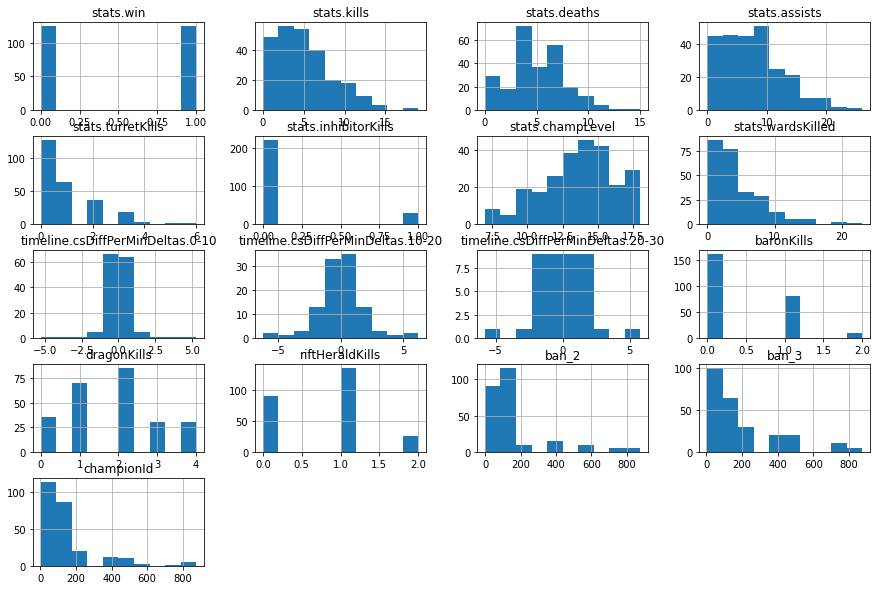

In [26]:
_ = player_stat.hist(figsize = (15, 10))

In [27]:
corrMatrix = player_stat.corr()

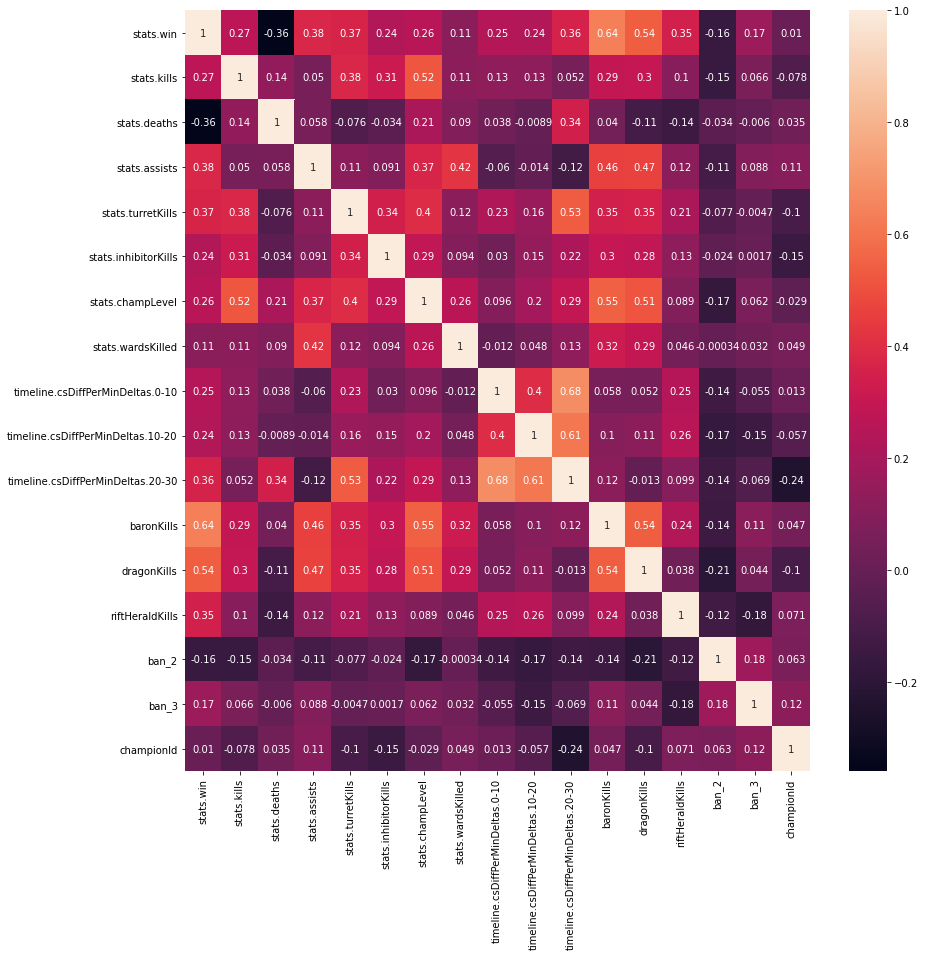

In [28]:
fig, ax = plt.subplots(figsize=(14,14))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [29]:
player_stat['championId'] = player_stat['championId'].astype('category')
player_stat = pd.concat([player_stat, pd.get_dummies(player_stat['championId'], prefix='champion_')], axis=1)

/home/david/Documents/league_recommendation/league_recommendation/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
player_stat.head()

,stats.win,stats.kills,stats.deaths,stats.assists,stats.turretKills,stats.inhibitorKills,stats.champLevel,stats.wardsKilled,timeline.csDiffPerMinDeltas.0-10,timeline.csDiffPerMinDeltas.10-20,...,champion__497,champion__498,champion__517,champion__518,champion__523,champion__526,champion__555,champion__777,champion__875,champion__876
0,1,1,3,19,2,0,15,13,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,7,6,9,1,0,17,2,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2,1,5,7,7,2,0,16,7,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1,6,8,10,0,1,15,2,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1,11,5,9,2,0,16,13,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Fill NA's with mean

In [31]:
player_stat = player_stat.fillna(player_stat.mean())

In [32]:
for col in player_stat[['baronKills', 'riftHeraldKills']]:
    print(player_stat[col].unique())

[2 0 1]
[2 0 1]


In [33]:
x = player_stat.drop(['stats.win', 'riftHeraldKills', 'baronKills'], axis=1)
x = x.loc[:, ~x.columns.str.startswith('ban')]
x = x.loc[:, ~x.columns.str.startswith('champion')]
y = player_stat['stats.win']

In [57]:
print(x.shape)
print(x.columns)

(250, 11)
Index(['stats.kills', 'stats.deaths', 'stats.assists', 'stats.turretKills',
       'stats.inhibitorKills', 'stats.champLevel', 'stats.wardsKilled',
       'timeline.csDiffPerMinDeltas.0-10', 'timeline.csDiffPerMinDeltas.10-20',
       'timeline.csDiffPerMinDeltas.20-30', 'dragonKills'],
      dtype='object')


In [34]:
x.head()

,stats.kills,stats.deaths,stats.assists,stats.turretKills,stats.inhibitorKills,stats.champLevel,stats.wardsKilled,timeline.csDiffPerMinDeltas.0-10,timeline.csDiffPerMinDeltas.10-20,timeline.csDiffPerMinDeltas.20-30,dragonKills
0,1,3,19,2,0,15,13,6.083414e-18,-8.379042e-18,0.0,2
1,7,6,9,1,0,17,2,6.083414e-18,-8.379042e-18,0.0,2
2,5,7,7,2,0,16,7,6.083414e-18,-8.379042e-18,0.0,2
3,6,8,10,0,1,15,2,6.083414e-18,-8.379042e-18,0.0,2
4,11,5,9,2,0,16,13,6.083414e-18,-8.379042e-18,0.0,2


In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [36]:
scaler = StandardScaler()

In [37]:
x_train = scaler.fit_transform(x_train)

### Logistic Regression

In [38]:
model = LogisticRegression(random_state = 42)

In [39]:
model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [40]:
x_test = scaler.transform(x_test)

In [41]:
y_pred = model.predict(x_test)
y_pred

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [42]:
model.score(x_train, y_train)

0.8770053475935828

In [43]:
model.score(x_test, y_test)

0.7619047619047619

#### Confusion Matrix

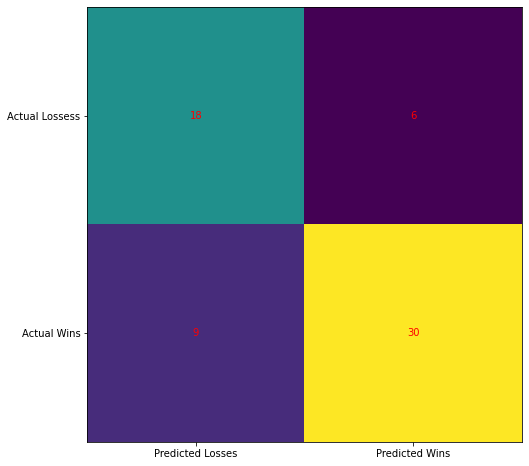

In [44]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Losses', 'Predicted Wins'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Lossess', 'Actual Wins'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        24
           1       0.83      0.77      0.80        39

    accuracy                           0.76        63
   macro avg       0.75      0.76      0.75        63
weighted avg       0.77      0.76      0.76        63



### Random Forest Classification

In [46]:
model_rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [47]:
model_rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [48]:
y_pred_rfr = model_rfc.predict(x_test)
y_pred_rfr

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

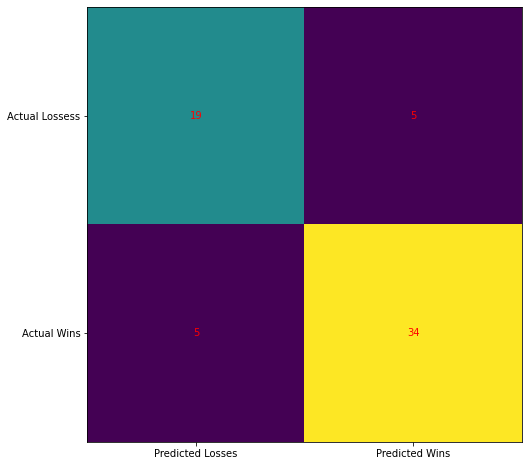

In [49]:
cm = confusion_matrix(y_test, y_pred_rfr)

fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Losses', 'Predicted Wins'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Lossess', 'Actual Wins'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [50]:
print(classification_report(y_test, y_pred_rfr))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        24
           1       0.87      0.87      0.87        39

    accuracy                           0.84        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.84      0.84      0.84        63



In [51]:
rfc_cv_score = cross_val_score(model_rfc, x, y, cv=10, scoring='roc_auc')
print(rfc_cv_score)
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

[0.78846154 0.66346154 1.         0.98717949 1.         1.
 0.70833333 0.93589744 0.80448718 0.8974359 ]
Mean AUC Score - Random Forest:  0.878525641025641


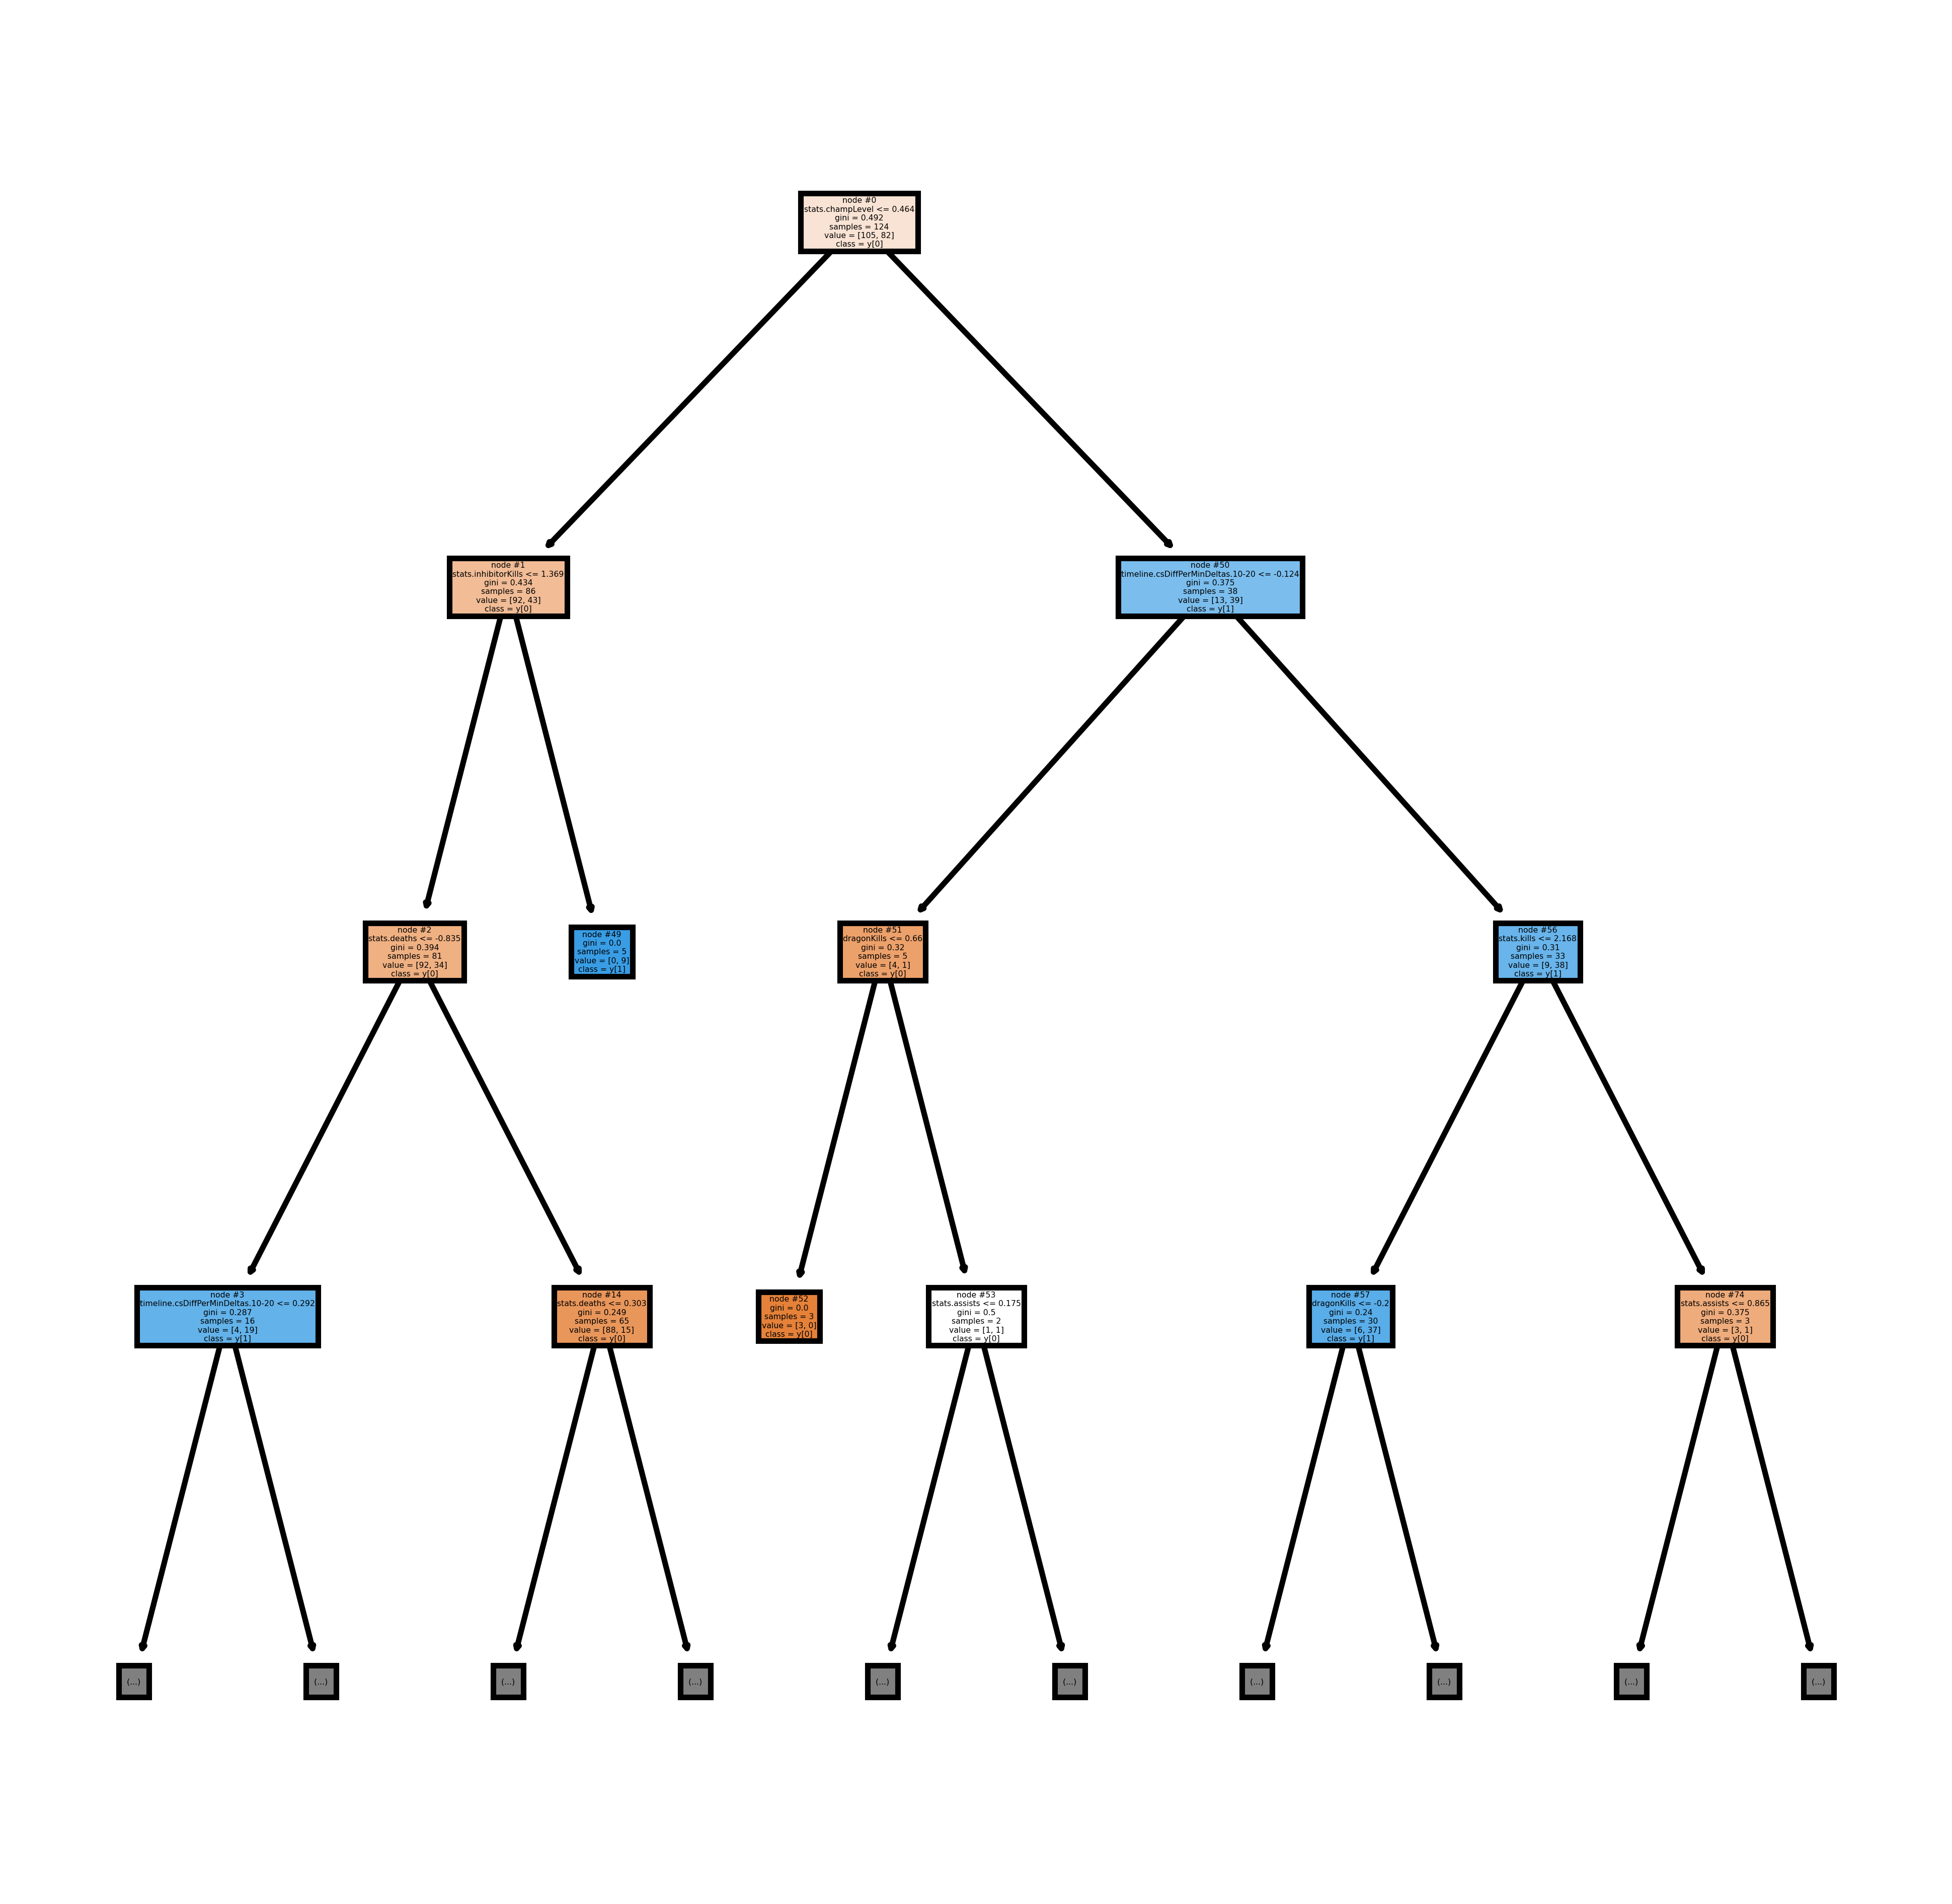

In [52]:
fn=x.columns
cn=y.name
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=800)
tree.plot_tree(model_rfc.estimators_[0],
               feature_names = fn, 
               class_names=True,
               filled = True,
              node_ids = True,
              max_depth = 3);

In [53]:
damage = pd.DataFrame(scaler.fit_transform(x['stats.trueDamageDealtToChampions'].values.reshape(-1,1)))
with pd.option_context('float_format', '{:f}'.format): print(damage.describe())

KeyError: 'stats.trueDamageDealtToChampions'

In [ ]:
scaler.inverse_transform(pd.DataFrame({'trueDamageDealtToChampions': [-0.226]}))

In [ ]:
drag = pd.DataFrame(scaler.fit_transform(x['dragonKills'].values.reshape(-1,1)))
with pd.option_context('float_format', '{:f}'.format): print(drag.describe())

In [ ]:
scaler.inverse_transform(pd.DataFrame({'dragonKills': [-0.37]}))

In [ ]:
turr = pd.DataFrame(scaler.fit_transform(x['stats.turretKills'].values.reshape(-1,1)))
with pd.option_context('float_format', '{:f}'.format): print(turr.describe())

In [ ]:
scaler.inverse_transform(pd.DataFrame({'turretKills': [0.021]}))